In [76]:
import sys  
sys.path.insert(0, '../Code')

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn


from matplotlib.font_manager import FontProperties
from shutil import copyfile
from pathlib import Path

import taxa
from data import *
from visualization import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [81]:
import warnings
warnings.filterwarnings('ignore')

In [70]:
pd.set_option('display.max_rows', None)

GROUP = 'Group'
GENOME_ID = 'Genome ID'
LABEL = 'Label'

WSPC = 'WSPC'
BACPACS = 'BacPaCS'
PATHOGENFINDER = 'Pathogenfinder'

PRED = 'predictions'
PREDICTION_PROB = 'predictions_probs'

SEN = 'Sensitivity'
SPE = 'Specificity'
BACC = 'BACC'

TARGET_NAMES = ['NHP', 'HP']

In [77]:
path = Path('..\Data')

train_genomes = MetadataReader.read(path /'train_genomes_info.csv')

test_genome_verified = MetadataReader.read(path / 'test_genomes_verified.csv')
test_genome_verified[LABEL] = test_genome_verified[LABEL].apply(lambda label: GenomesData.label_to_int.get(label))

test_genome_verified.head()

,Genome Name,Label,HP/NHP,species,References,Group,Host Name,Isolation Source,Isolation Comments,Genome Quality,Collection Date,Date Inserted,Other Clinical,Host Health,Disease,Comments
Genome ID,,,,,,,,,,,,,,,,
163603.4,Actinomadura latina strain ATCC BAA-277,1,1/0,Actinomadura latina,\cite{trujillo1997polyphasic},HP,"Human, Homo sapiens",arm of patient,NaN,Good,NaN,2020-04-26 17:38:00.943000+00:00,NaN,NaN,NaN,MicrobeNet genomes
648.157,Aeromonas caviae strain ScAc2001,1,9/0,Aeromonas caviae,\cite{tang2020co},HP,"Human, Homo sapiens",Watery diarrhea,NaN,Good,2019-05,2020-01-31 23:41:12.327000+00:00,NaN,Diarrhea,NaN,Whole genome sequenced and analysis MDR isolat...
565.15,Atlantibacter hermannii strain 3608,1,1/0,Atlantibacter hermannii,\cite{ioannou2019escherichia},HP,"Human, Homo sapiens",Wound swab,NaN,Good,2015,2020-02-07 13:50:54.571000+00:00,NaN,Wound infection 8,NaN,Extended Spectrum beta-lactamase producing Ent...
29459.655,Brucella melitensis strain HN20190002,1,13/0,Brucella melitensis,\cite{li2020molecular},HP,"Human, Homo sapiens",NaN,NaN,Good,2019-02-04,2020-01-31 21:07:14.657000+00:00,NaN,NaN,NaN,"strain was obtained from patients in Hainan,China"
87883.284,Burkholderia multivorans strain C1576,1,107/0,Burkholderia multivorans,\cite{silva2016long},HP,"Human, Homo sapiens",sputum,isolated from a cystic fibrosis patient,Good,1992,2020-03-27 14:33:49.442000+00:00,NaN,Cystic fibrosis,NaN,Whole genome sequencing of a clinical isolate ...


In [4]:
test_genome_verified[GROUP].value_counts()

OHP     77
NHP     61
ONHP    41
HP      25
Name: Group, dtype: int64

In [49]:
all_methods_preds = test_genome_verified[[LABEL]].copy()

In [5]:
def calculate_results_per_group(test_genomes, preds):
    
    results_dict = {}
    
    for group_name, genomes in test_genomes.groupby(GROUP):
        
        y_test_group = test_genomes.loc[genomes.index][LABEL]
        y_pred = preds.loc[genomes.index][PRED]
        correct = sklearn.metrics.accuracy_score(y_test_group, y_pred, normalize=False)
        accuracy = sklearn.metrics.accuracy_score(y_test_group, y_pred)
        
        print(f'{group_name}\taccuracy={accuracy:.2f} correctly predicted={correct}/{len(y_test_group)}')
        
        if PREDICTION_PROB in preds.columns:
            y_probs = preds.loc[genomes.index][PREDICTION_PROB]
            average_score = np.average(y_probs)
            print(f'Average score={average_score:.2f}')
            
        results_dict[group_name] = accuracy
        
    return results_dict

# bacpacs results

In [6]:
bacpacs_pred_arr = pd.read_csv('bacpacs_prediction_on_newTest14.2.21.csv')  
bacpacs_pred_arr['genome_id'] = bacpacs_pred_arr['genome_id'].str.strip('.PATRIC')
bacpacs_pred_arr = bacpacs_pred_arr.set_index('genome_id') 

In [32]:
bacpacs_pred_arr

,predictions
genome_id,
104608.5,0
104628.50,1
109328.8,0
1117645.412,1
1134687.181,1
119602.327,1
1202713.3,1
1246.49,0
1260.144,0


In [7]:
print('BacPaCS results:')

bacpacs_results = calculate_results_per_group(test_genome_verified, bacpacs_pred_arr)

BacPaCS results:
HP	accuracy=0.96 correctly predicted=24/25
NHP	accuracy=0.72 correctly predicted=44/61
OHP	accuracy=0.82 correctly predicted=63/77
ONHP	accuracy=0.73 correctly predicted=30/41


In [51]:
all_methods_preds.loc[bacpacs_pred_arr.index, BACPACS] = bacpacs_pred_arr[PRED]
all_methods_preds.head()

,Label,BacPaCS
Genome ID,,
163603.4,1,1
648.157,1,1
565.15,1,1
29459.655,1,1
87883.284,1,1


# pathogenfinder results

In [52]:
folder = 'results pathogenfinder/'
files = os.listdir(folder)
pathogenfinder_preds = pd.DataFrame(index = test_genome_verified.index, columns = ['predictions'], dtype=int)

for name in files:
    if name.startswith('PathogenFinder_cdhit_raw'): continue
        
    genome_id = name.split('.txt', 1)[0].split('_')[2]
    if genome_id in  test_genome_verified.index:
            with open(folder + name , 'r') as input_file:
                for line in input_file: 
                    if line.startswith('The organisms is predicted as human pathogenic ::'):
                        predicted_pathogen = line.strip().split('\t')[1]
                        if predicted_pathogen == 'Yes': pathogenfinder_preds.at[genome_id, 'predictions'] = 1
                        elif predicted_pathogen == 'No': pathogenfinder_preds.at[genome_id, 'predictions'] = 0
                        else: print(f'Error in results of file: {name}')
                    # Validate that the file name match the input sequence
                    if line.startswith('#input_seq:'):
                        seq_id =  line.split('fig|')[1].split('.peg')[0]
                        if genome_id != seq_id: print(f'Error in file name: {name}')
                        break

In [53]:
pathogenfinder_preds.head()

,predictions
Genome ID,
163603.4,0.0
648.157,1.0
565.15,1.0
29459.655,1.0
87883.284,1.0


In [59]:
all_methods_preds.loc[pathogenfinder_preds.index, PATHOGENFINDER] = pathogenfinder_preds[PRED]

In [56]:
all_methods_preds.head()

,Label,BacPaCS,Pathogenfinder
Genome ID,,,
163603.4,1,1,0.0
648.157,1,1,1.0
565.15,1,1,1.0
29459.655,1,1,1.0
87883.284,1,1,1.0


In [54]:
print('Pathogenfinder results:')
pathogenfinder_results = calculate_results_per_group(test_genome_verified, pathogenfinder_preds)

Pathogenfinder results:
HP	accuracy=0.96 correctly predicted=24/25
NHP	accuracy=0.59 correctly predicted=36/61
OHP	accuracy=0.86 correctly predicted=66/77
ONHP	accuracy=0.29 correctly predicted=12/41


# WSPC results

In [10]:
wspc_preds = pd.read_csv('wspc_test_preds.csv', dtype={GENOME_ID: str}).set_index(GENOME_ID)

In [60]:
all_methods_preds.loc[wspc_preds.index, WSPC] = wspc_preds[PRED]

In [61]:
all_methods_preds.head()

,Label,BacPaCS,Pathogenfinder,WSPC
Genome ID,,,,
163603.4,1,1,0.0,1
648.157,1,1,1.0,1
565.15,1,1,1.0,1
29459.655,1,1,1.0,1
87883.284,1,1,1.0,1


In [11]:
wspc_results = calculate_results_per_group(test_genome_verified, wspc_preds)

HP	accuracy=1.00 correctly predicted=25/25
Average score=0.94
NHP	accuracy=0.93 correctly predicted=57/61
Average score=0.13
OHP	accuracy=0.92 correctly predicted=71/77
Average score=0.90
ONHP	accuracy=0.59 correctly predicted=24/41
Average score=0.43


# Comparative plots

In [14]:
results = {WSPC: wspc_results, BACPACS: bacpacs_results, PATHOGENFINDER: pathogenfinder_results}
bar_groups = ['HP', 'NHP', 'OHP', 'ONHP']
bars = [WSPC, BACPACS, PATHOGENFINDER]

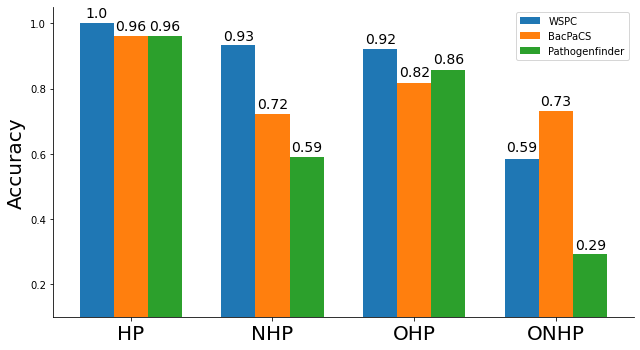

In [21]:
figs_output = Path('..\Paper\Figures')

out_path = figs_output / 'comparative_wspc_test_groups.pdf'

create_grouped_barplots(results, bar_groups, bars, out_path, bar_width=0.24, fig_size=(9, 5), y_label='Accuracy',
                            x_ticks_font_size=20, legend_loc='upper right')

In [63]:
def report_to_metrics(report):
    
    specificity = round(report['NHP']['recall'], 2)
    sensitivity = round(report['HP']['recall'], 2)
    bacc = round(report['macro avg']['recall'], 2)

    
    return {SPE: specificity, SEN: sensitivity, BACC: bacc}

In [64]:
def get_cls_results(genomes, all_methods_preds, methods, measures):
    
    results = {}

    for method in methods:
        preds = all_methods_preds.loc[genomes, method]
        labels = all_methods_preds.loc[genomes, LABEL]
        report = classification_report(labels, preds, target_names=TARGET_NAMES, output_dict=True)
        method_results = report_to_metrics(report) 
        results[method] = method_results

    return results

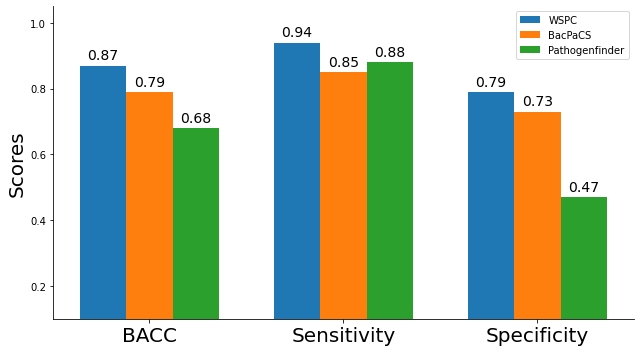

In [83]:
fig_name = 'Comparative_wspc_test_general.pdf'
out_path = figs_output / fig_name

methods = [WSPC, BACPACS, PATHOGENFINDER]
measures = [BACC, SEN, SPE]

general_results = get_cls_results(all_methods_preds.index, all_methods_preds, all_methods_preds.columns, measures)

create_grouped_barplots(general_results, bar_groups=measures, bars=methods, out_path=out_path, bar_width=0.24, fig_size=(9, 5))

In [82]:
novel_species = taxa.get_novel_species(train_genomes.index, test_genome_verified.index)
novel_species_genomes = taxa.get_genomes_with_tax(test_genome_verified.index, novel_species, taxa.SPECIES)

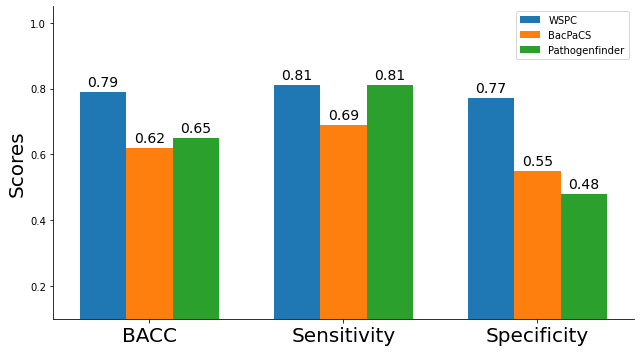

In [85]:
fig_name = 'Comparative_wspc_test_novel_species.pdf'
out_path = figs_output / fig_name

novel_sepcies_results = get_cls_results(novel_species_genomes, all_methods_preds, all_methods_preds.columns, measures)

create_grouped_barplots(novel_sepcies_results, bar_groups=measures, bars=methods, out_path=out_path, bar_width=0.24, 
                        fig_size=(9, 5))